In [1]:
import pandas as pd
import datetime
import gc
from sklearn.ensemble import (
BaggingRegressor, RandomForestClassifier, AdaBoostRegressor)
from sklearn.metrics import mean_squared_error
from technical_indicators import * # import all function
from sklearn.model_selection import TimeSeriesSplit
import parfit as pf
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from statistics import mode

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# read in our data
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)
#df_ORIGINAL = pd.read_csv('AAPL.csv')

In [3]:
df_features = df_ORIGINAL
df_features.drop(['Adj Close'], axis = 1, inplace = True)
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.head()

Date        High         Low        Open       Close   Volume
0 2002-01-02  121.500000  119.800003  120.599999  121.500000  6862800
1 2002-01-03  124.220001  120.250000  121.500000  123.660004  8621700
2 2002-01-04  125.599999  123.980003  124.050003  125.599999  8405200
3 2002-01-07  126.190002  123.699997  125.000000  124.050003  5939600
4 2002-01-08  125.199997  123.730003  124.250000  124.699997  5311800

In [4]:
## Create Lag Features
#this is exactly what the book does for create_lag_features from chapter 29
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 1):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate if today stock is going up or down
    df_ret['Today updown'] = np.where(df_ret['Close']>df_ret['value_lag1'], 1, 0)
    
    # calculate if yesterday stock is going up or down
    for i in range(1,lag_days):
        df_ret[str(i) + 'day updown'] = np.where(df_ret['value_lag' + str(i)] > df_ret['value_lag' + str(i+1)], 1, 0)
    
    

    
    df_ret['AvgUpDown'] = -1
    updown = []
    for i in range(len(df_ret.iloc[:,0])):
        updown = []
        updown.append(df_ret.loc[i,'Today updown'])
        for j in range(1,lag_days):
            updown.append(df_ret.loc[i, str(j) + 'day updown'])
        
        df_ret.loc[i,'AvgUpDown'] = np.average(updown)
        #df_ret.loc[i, 'ModeUpDownPast'] = mode(updown)
     
    pric = []
    for i in range(len(df_ret.iloc[:,0])):
        price = []
        high = 0
        low = 0
        for j in range(1, lag_days+1):
            price.append(df_ret.loc[i,'value_lag' + str(j)])
        high = max(price)
        low = min(price)
        df_ret.loc[i, 'WillR'] = ((high-df_ret.loc[i,'Close'])/(high - low)) *100
    
    # drop
    for i in range(1,lag_days + 1):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
    
#     #calculate today's percentage lag
#     df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
#     # calculate percentage lag
#     for i in range(1, lag_days + 1):
#         df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
#     # drop unneeded columns which are value_lags
#     for i in range(1, lag_days + 2):
#         df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret

In [5]:
df_features = create_lag_features(df_features, 30) # 5 lag features
df_features.head(20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars


Date        High         Low        Open       Close    Volume  \
0  2002-01-02  121.500000  119.800003  120.599999  121.500000   6862800   
1  2002-01-03  124.220001  120.250000  121.500000  123.660004   8621700   
2  2002-01-04  125.599999  123.980003  124.050003  125.599999   8405200   
3  2002-01-07  126.190002  123.699997  125.000000  124.050003   5939600   
4  2002-01-08  125.199997  123.730003  124.250000  124.699997   5311800   
5  2002-01-09  126.389999  124.150001  124.699997  124.489998   6839900   
6  2002-01-10  124.000000  121.419998  123.750000  122.139999   8926300   
7  2002-01-11  122.180000  120.279999  121.500000  120.309998   4797800   
8  2002-01-14  120.089996  117.099999  120.000000  118.050003  10026700   
9  2002-01-15  119.699997  117.720001  118.050003  118.849999   5647900   
10 2002-01-16  118.750000  117.250000  118.000000  117.400001   5366300   
11 2002-01-17  120.550003  117.260002  119.849999  119.900001  11153700   
12 2002-01-18  114.900001  112.809998  114.250000  114.250000  18440200   
13 2002-01-22  114.260002  110.330002  114.250000  110.500000  10130400   
14 2002-01-23  111.250000  107.000000  110.800003  107.900001  12556700   
15 2002-01-24  109.730003  107.070000  108.800003  108.720001   8581500   
16 2002-01-25  110.690002  108.099999  108.500000  109.279999   6761800   
17 2002-01-28  110.209999  107.059998  109.500000  108.150001   7092900   
18 2002-01-29  108.559998  102.410004  108.150001  103.000000  14509400   
19 2002-01-30  105.750000  101.000000  104.250000  105.550003  17713300   

    Today updown  1day updown  2day updown  3day updown     ...      \
0              0            0            0            0     ...       
1              1            0            0            0     ...       
2              1            1            0            0     ...       
3              0            1            1            0     ...       
4              1            0            1            1     ...       
5              0            1            0            1     ...       
6              0            0            1            0     ...       
7              0            0            0            1     ...       
8              0            0            0            0     ...       
9              1            0            0            0     ...       
10             0            1            0            0     ...       
11             1            0            1            0     ...       
12             0            1            0            1     ...       
13             0            0            1            0     ...       
14             0            0            0            1     ...       
15             1            0            0            0     ...       
16             1            1            0            0     ...       
17             0            1            1            0     ...       
18             0            0            1            1     ...       
19             1            0            0            1     ...       

    22day updown  23day updown  24day updown  25day updown  26day updown  \
0              0             0             0             0             0   
1              0             0             0             0             0   
2              0             0             0             0             0   
3              0             0             0             0             0   
4              0             0             0             0             0   
5              0             0             0             0             0   
6              0             0             0             0             0   
7              0             0             0             0             0   
8              0             0             0             0             0   
9              0             0             0             0             0   
10             0             0             0             0             0   
11             0             

In [6]:
# reset index
df_features.reset_index(drop = True, inplace = True)

#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = moving_average(df_features, 5)
df_features = moving_average(df_features, 10)
df_features = momentum(df_features, 1)
df_features = momentum(df_features, 3)
df_features = momentum(df_features, 5)
df_features = momentum(df_features, 10)
df_features = exponential_moving_average(df_features, 5)
df_features = exponential_moving_average(df_features, 10)
df_features = macd(df_features, 26, 12)
df_features = relative_strength_index(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = chaikin_oscillator(df_features)
df_features = rate_of_change(df_features, 3)
df_features = trix(df_features, 14)
df_features = money_flow_index(df_features, 14)

#added
df_features = standard_deviation(df_features, 14)

df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
# df_features = moving_average(df_features, 21) # periods
# df_features = exponential_moving_average(df_features, 21) # periods
# df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)

df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

# #df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
# df_features = chaikin_oscillator(df_features)
# df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
#df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)

df_features = df_features.reset_index(drop = True)

In [7]:
df_features.head()

Date        High         Low        Open       Close   Volume  \
0 2002-01-02  121.500000  119.800003  120.599999  121.500000  6862800   
1 2002-01-03  124.220001  120.250000  121.500000  123.660004  8621700   
2 2002-01-04  125.599999  123.980003  124.050003  125.599999  8405200   
3 2002-01-07  126.190002  123.699997  125.000000  124.050003  5939600   
4 2002-01-08  125.199997  123.730003  124.250000  124.699997  5311800   

   Today updown  1day updown  2day updown  3day updown     ...       \
0             0            0            0            0     ...        
1             1            0            0            0     ...        
2             1            1            0            0     ...        
3             0            1            1            0     ...        
4             1            0            1            1     ...        

   KST_10_10_10_15_10_15_20_30  TSI_25_13  OBV_14  Force_14  EoM_14  \
0                          NaN        NaN     NaN       NaN     NaN   
1                          NaN        NaN     NaN       NaN     NaN   
2                          NaN        NaN     NaN       NaN     NaN   
3                          NaN        NaN     NaN       NaN     NaN   
4                          NaN        NaN     NaN       NaN     NaN   

   KelChM_14  KelChU_14  KelChD_14  Ultimate_Osc  Donchian_14  
0        NaN        NaN        NaN           NaN          NaN  
1        NaN        NaN        NaN           NaN          NaN  
2        NaN        NaN        NaN           NaN          NaN  
3        NaN        NaN        NaN           NaN          NaN  
4        NaN        NaN        NaN           NaN          NaN  

[5 rows x 81 columns]

In [8]:
def predict_days_ahead(df, days):
    df['LabelUpDown'] = -1
    
    df_a = df.copy()
    df_a = df_a[['Date', 'Close']]
    # future prices
    df_a['Date'] = df_a['Date'].shift(days)
    df_a.columns = ['Date', 'Close Future']
    
    # combine the future prices into today's row
    df = pd.merge(df, df_a, how = 'left', left_on = 'Date', right_on = 'Date')
    
    # generate feature up/down in future days
    df['LabelUpDown'] = np.where(df['Close Future'] > df['Close'], 1, 0)
    df.drop(['Close Future'], axis = 1, inplace = True)
    
    return df

In [9]:
df_features = predict_days_ahead(df_features, 1)

In [10]:
np.bincount(df_features['LabelUpDown'])

array([2112, 2128], dtype=int64)

In [11]:
# drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)

# set index as date
df_features = df_features.set_index(['Date'])

# stores all labels
y = df_features['LabelUpDown']

# drop unneded columns
# df_features.drop(['Open','Close','Low','High', 'Volume', 'LabelUpDown'], axis = 1, inplace = True)

df_features.drop(['LabelUpDown'], axis = 1, inplace = True)

In [12]:
# from sklearn.model_selection import train_test_split

# X_train_all, X_test, y_train_all, y_test = train_test_split(df_features, y, train_size = 0.9, random_state = 0)

In [13]:
#all training data
X_train_all = df_features.loc[(df_features.index < '2018-01-01')]
y_train_all = y[X_train_all.index]

# creates all test data which is all after January 2018
X_test = df_features.loc[(df_features.index >= '2018-01-01'),:]
y_test = y[X_test.index]

In [14]:
print('Train', np.bincount(y_train_all))
print('tetst', np.bincount(y_test))

Train [1983 2002]
tetst [105 106]


In [15]:
display(X_train_all.head())

High         Low        Open       Close    Volume  \
Date                                                                   
2002-03-06  107.089996  104.750000  105.150001  106.300003   7687400   
2002-03-07  107.500000  103.239998  107.300003  103.709999  10971900   
2002-03-08  107.339996  104.820000  104.820000  105.089996  10726400   
2002-03-11  105.970001  103.599998  104.349998  105.239998   8639100   
2002-03-12  108.849999  105.510002  105.519997  108.500000  11059300   

            Today updown  1day updown  2day updown  3day updown  4day updown  \
Date                                                                           
2002-03-06             1            0            1            1            1   
2002-03-07             0            1            0            1            1   
2002-03-08             1            0            1            0            1   
2002-03-11             1            1            0            1            0   
2002-03-12             1            1            1            0            1   

               ...       KST_10_10_10_15_10_15_20_30  TSI_25_13        OBV_14  \
Date           ...                                                              
2002-03-06     ...                        -11.702531  -0.158320 -2.273986e+06   
2002-03-07     ...                        -10.962397  -0.140301 -2.642243e+06   
2002-03-08     ...                         -9.767415  -0.115700 -5.757429e+05   
2002-03-11     ...                         -8.347016  -0.095070  9.981857e+05   
2002-03-12     ...                         -6.754872  -0.054884  2.825650e+06   

                Force_14        EoM_14   KelChM_14   KelChU_14  KelChD_14  \
Date                                                                        
2002-03-06 -4.602876e+06  6.503824e-08  101.176905  104.142619  98.211191   
2002-03-07 -2.155041e+07  2.883100e-08  100.943809  104.074523  97.813095   
2002-03-08 -1.645202e+07  1.006500e-07  101.130952  104.220237  98.041667   
2002-03-11 -1.874177e+07  1.210493e-07  101.436904  104.485475  98.388334   
2002-03-12 -3.185163e+07  1.997117e-07  102.069047  105.141903  98.996191   

            Ultimate_Osc  Donchian_14  
Date                                   
2002-03-06      4.005378     9.209999  
2002-03-07      3.696528     8.300003  
2002-03-08      3.799361    10.440002  
2002-03-11      4.005949    12.300003  
2002-03-12      3.910883    13.290001  

[5 rows x 80 columns]

In [16]:
X_train_all_standardized = X_train_all
X_test_standardized = X_test
datestrain = X_train_all_standardized.index # get dates to set as index after data is standardized
names = X_train_all_standardized.columns # Get column names first

datestest = X_test.index

# Standardize
sc = StandardScaler()
X_train_all_standardized = sc.fit_transform(X_train_all_standardized)
X_test_standardized = sc.transform(X_test_standardized)

# Convert to DataFrame
X_train_all_standardized = pd.DataFrame(X_train_all_standardized, columns=names, index=datestrain)
X_test_standardized = pd.DataFrame(X_test_standardized, columns = names, index = datestest)

X_train_all_standardized.head(7)

High       Low      Open     Close    Volume  Today updown  \
Date                                                                         
2002-03-06 -0.590266 -0.600732 -0.612528 -0.586866  0.509665      0.995243   
2002-03-07 -0.580520 -0.636846 -0.561262 -0.648609  1.528110     -1.004779   
2002-03-08 -0.584323 -0.599058 -0.620397 -0.615711  1.451987      0.995243   
2002-03-11 -0.616890 -0.628236 -0.631604 -0.612135  0.804765      0.995243   
2002-03-12 -0.548428 -0.582556 -0.603705 -0.534421  1.555211      0.995243   
2002-03-13 -0.553182 -0.554095 -0.537417 -0.565888  0.113326     -1.004779   
2002-03-14 -0.569823 -0.556726 -0.567938 -0.579714 -0.219603     -1.004779   

            1day updown  2day updown  3day updown  4day updown     ...       \
Date                                                               ...        
2002-03-06    -1.004779     0.995243     0.995243     0.995243     ...        
2002-03-07     0.995243    -1.004779     0.995243     0.995243     ...        
2002-03-08    -1.004779     0.995243    -1.004779     0.995243     ...        
2002-03-11     0.995243    -1.004779     0.995243    -1.004779     ...        
2002-03-12     0.995243     0.995243    -1.004779     0.995243     ...        
2002-03-13     0.995243     0.995243     0.995243    -1.004779     ...        
2002-03-14    -1.004779     0.995243     0.995243     0.995243     ...        

            KST_10_10_10_15_10_15_20_30  TSI_25_13    OBV_14  Force_14  \
Date                                                                     
2002-03-06                    -2.048847  -0.864119 -1.247702 -0.023124   
2002-03-07                    -1.924455  -0.778077 -1.449587 -0.536138   
2002-03-08                    -1.723617  -0.660609 -0.316695 -0.381806   
2002-03-11                    -1.484895  -0.562097  0.546161 -0.451119   
2002-03-12                    -1.217307  -0.370205  1.548009 -0.847964   
2002-03-13                    -0.897748  -0.259189  1.693777 -1.100766   
2002-03-14                    -0.666037  -0.188979  1.074796 -1.150901   

              EoM_14  KelChM_14  KelChU_14  KelChD_14  Ultimate_Osc  \
Date                                                                  
2002-03-06  0.298542  -0.707884  -0.681786  -0.734067      0.595871   
2002-03-07  0.113788  -0.713451  -0.683402  -0.743633      0.173707   
2002-03-08  0.480257  -0.708981  -0.679944  -0.738141      0.314268   
2002-03-11  0.584349  -0.701674  -0.673649  -0.729811      0.596652   
2002-03-12  0.985738  -0.686577  -0.658072  -0.715205      0.466707   
2002-03-13  1.126250  -0.669267  -0.643822  -0.694803      0.099250   
2002-03-14  1.133523  -0.653499  -0.631679  -0.675369     -0.294072   

            Donchian_14  
Date                     
2002-03-06     0.048537  
2002-03-07    -0.146182  
2002-03-08     0.311730  
2002-03-11     0.709728  
2002-03-12     0.921565  
2002-03-13     0.942963  
2002-03-14     0.942963  

[7 rows x 80 columns]

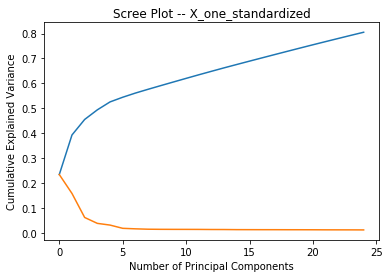

In [17]:
### 80% - 7 components
pca80 = PCA(.80).fit(X_train_all_standardized)
plt.plot(np.cumsum(pca80.explained_variance_ratio_))
plt.plot((pca80.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance');
plt.title('Scree Plot -- X_one_standardized')
plt.show()

In [18]:
# create PCA data
def create_column_names(numColumns):
    colNames = []
    for i in range(numColumns):
        tempName = "PC" + str(i+1)
        colNames.append(tempName)
        
    return colNames

# pca80
X_train_all_pca80 = pca80.transform(X_train_all_standardized)
X_train_all_pca80 = pd.DataFrame(X_train_all_pca80, columns=create_column_names(X_train_all_pca80.shape[1]), index=X_train_all_standardized.index)

X_test_pca80 = pca80.transform(X_test_standardized)
X_test_pca80 = pd.DataFrame(X_test_pca80, columns=create_column_names(X_test_pca80.shape[1]), index=X_test.index)

In [19]:
rf = RandomForestClassifier(max_depth = 6, random_state = 42, n_estimators = 100)

In [20]:
rf.fit(X_train_all_pca80, y_train_all)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
from sklearn.model_selection import cross_val_score

y_pred = rf.predict(X_test_pca80)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5355450236966824

In [23]:
accuracy_score(y_train_all, rf.predict(X_train_all_pca80))

0.8233375156838143

In [24]:
np.average(cross_val_score(rf, X_test_pca80, y_test, cv=10))

0.5325974025974026

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(random_state = 42)
logreg.fit(X_train_all_pca80, y_train_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
y_pred = logreg.predict(X_test_pca80)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_pca80, y_test)))

Accuracy of logistic regression classifier on test set: 0.50


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
np.average(cross_val_score(logreg, X_test_pca80, y_test, cv=100))

[[48 57]
 [48 58]]


0.4983333333333333

In [28]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(X_train_all_standardized, y_train_all)
y_knn = neigh.predict(X_test_standardized)
cross_val_score(neigh, X_test_pca80, y_test, cv=10)

array([0.36363636, 0.22727273, 0.54545455, 0.36363636, 0.40909091,
       0.52380952, 0.5       , 0.45      , 0.5       , 0.5       ])

In [29]:
accuracy_score(y_test, y_knn)

0.5118483412322274

In [30]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', random_state = 42, C = 1)
clf.fit(X_train_all_pca80, y_train_all)
y_pred = clf.predict(X_test_pca80)
accuracy_score(y_test, y_pred)
#cross_val_score(clf, X_test_pca80, y_test, cv=10)

0.5023696682464455

In [31]:
accuracy_score(y_train_all, clf.predict(X_train_all_pca80))

0.9031367628607277

In [32]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth = 5, n_estimators = 100, random_state = 42)
model.fit(X_train_all_pca80, y_train_all)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [33]:
accuracy_score(y_train_all, model.predict(X_train_all_pca80))

0.9141781681304894

In [34]:
accuracy_score(y_test, model.predict(X_test_pca80))

0.5165876777251185